In [374]:
import numpy;
import math;
import torch;
import matplotlib.pyplot as plt

plot = True

def getData(N, variance):
    """
    Generates a dataset {(xi, yi) : i = 1, 2, . . .N} of N (X, Y ) pairs for a given value of N and sigma^2
    :return: The generated dataset of (X,Y) pairs
    """
    X = numpy.random.rand(N) # N values between 0 and 1
    Z = numpy.random.normal(0, math.sqrt(variance), N) # Zero mean Gaussian random variable, with standard deviation, of length N
    Y = numpy.cos(2*math.pi*X) + Z # Y generated from function (1)
    #print("X: ", X)
    #print("Z: ", Z)
    #print ("Y: ", Y)

    # store the (X,Y) pairs in a N x 2 matrix
    x_y_pair_matrix = numpy.column_stack((X, Y))
    #print("(X,Y) pairs:", x_y_pair_matrix)
    # optionally plot the dataset that is created
    if plot:
        plt.scatter(X,Y, label="My Random Dataset", marker='x')
        plt.title('Generated Dataset for cos(2*pi*x) from 0 to 1')
    return x_y_pair_matrix

def getMSE_Updated(data_set, poly_coefficients):
    x_values = data_set[:, 0] # Values of x from given dataset
    y_true_values = data_set[:, 1] # Values of y from given dataset

    y_predicted= numpy.dot(poly_coefficients, x_values**numpy.arrange(len(poly_coefficients)))

    # MSE calculation using numpy, but will manually calculate below
    mse = numpy.mean((y_true_values - y_predicted)**2) 
    print ("Automatic MSE:", mse)

    # Sum all the squared differences of each y_pred, y_true. Then average that over the vector length, N 
    summation_diffs_squared = 0
    for y_pred_i, y_true_i in zip(y_predicted, y_true_values):
        squared_diff = (y_pred_i - y_true_i) ** 2
        summation_diffs_squared += squared_diff
    mse = summation_diffs_squared / len(y_true_values)
    print ("Calculated MSE: ", mse)
    return mse

# Old MSE algorithm, I think it took the wrong values (y_pred, y_true isn't enough)
def getMSEOld(y_predicted, y_true): # this is probably wrong, likely needs to take a dataset (X,Y) and a polynomial functions (x^2 + x + 2 ...)
    """
    Get the Mean Square Error (MSE) loss from the predicted dataset, and the true dataset
    :return: The Mean Square Error (MSE)
    """
    # MSE calculation using numpy, but will manually calculate below
    mse = numpy.mean((y_true - y_predicted)**2) 
    #print ("Automatic MSE:", mse)

    # print("\n")
    # print(y_predicted)
    # print(y_true)
    # print("\n")

    # N = len(y_predicted) # This one needs basic arrays, arrays in arrays fail
    # summation_diffs_squared = 0
    # for i in range(len(y_predicted)):
    #     squared_diff = (y_predicted[i] - y_true[i]) ** 2
    #     summation_diffs_squared += squared_diff
    # mse = summation_diffs_squared / N
    # print ("Calculated MSE: ", mse)
    return mse

def fitData(data_set, degree_poly):
    """
    fitData method that estimates the polynomial coefficients by fitting a given data to a degree-d polynomial
    :return: estimated_coefficients, Ein (MSE), Eout
    """
    # Hyperparameters of GD
    learning_rate = 0.1
    iterations = 1000
    X_values = numpy.array(data_set[:, 0]) # Values of x from given dataset, vector is 1xN
    Y_values = numpy.array(data_set[:, 1]) # Values of y from given dataset, vector is 1xN
    N = len(Y_values)
    print("Real X values:\n", X_values)
    print("Real Y values:\n", Y_values)

    # Random starting coefficents
    weights = startingRandomCoeffs(degree_poly+1) # vector is 1xD
    print("Staring Weights:\n", weights)

    X_polynomial = numpy.poly1d(weights)
    print("Poly function auto\n", X_polynomial, "\n")

    # Vandermonde matrix, for all X values, without coefficients of N X (D+1) size
    vander_matrix = numpy.vander(X_values, degree_poly+1, True)
    print("Vander Matrix:\n", vander_matrix)

    Y_pred = Y_values - vander_matrix.dot(weights)

    for x in range(iterations):

        Y_pred = Y_values - vander_matrix.dot(weights)
        
        grad = 2*(learning_rate/N) * ((Y_values - Y_pred)).dot(vander_matrix)
        if x % 100 is 0:
            #print("Predicted Y values:\n", Y_pred)
            print("Current MSE:", getMSEOld(Y_pred, Y_values))
            print("Gradients:\n", grad)
        # weights_new = weights_old + 
        weights -= grad

    if plot:
        plt.scatter(X_values,Y_pred, label="My Random Dataset", marker='o')
        plt.title('Predicted Y Values')

    Ein = 2.345
    Eout = 4.567
    return weights, Ein, Eout # this should be changed to the eventual estimated coefficients

def startingRandomCoeffs(d):
    """
    Get starting random coefficients, a0, a1, ..., ad, for the polynomial regression function
    :return: Randome coefficients for the polynomial based on random values between 0 and 1
    """
    return numpy.random.rand(d)

<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Nathan\AppData\Local\Temp\ipykernel_16008\2336923239.py:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x % 100 is 0:


Real X values:
 [0.89287483 0.01138963 0.53663253 0.15868153 0.41486864 0.8357009
 0.70480108 0.34091795 0.94317394 0.69891059 0.27041876 0.32558623
 0.02755879 0.06514355 0.70062506 0.9848079  0.73766421 0.06518727
 0.36745354 0.48140637 0.08472086 0.83466641 0.39498523 0.02869023
 0.62920719 0.10661062 0.03555848 0.62340219 0.61806092 0.63583314
 0.16317821 0.62603202 0.78971288 0.76041277 0.46320449 0.07768796
 0.04542352 0.69979939 0.90286679 0.11426662 0.20178452 0.7273915
 0.51278532 0.83754675 0.33894573 0.94622774 0.44593449 0.86325929
 0.53243657 0.03351365 0.34604701 0.7837606  0.63049706 0.72313981
 0.77564947 0.64000438 0.22881975 0.99807173 0.50403434 0.77178739
 0.03005844 0.30793944 0.22195945 0.7006281  0.40141589 0.66127234
 0.7554344  0.60913901 0.70677323 0.44333597 0.54890757 0.1948213
 0.27555066 0.09490768 0.30787467 0.4363652  0.71239424 0.51143684
 0.52479625 0.13674187 0.10407206 0.97588922 0.69450949 0.63759503
 0.87124344 0.26252803 0.360142   0.67353192 0.98

(array([-0.00053477, -0.02024202,  0.15100354, -0.24491626,  0.04680353,
         0.07352168]),
 2.345,
 4.567)

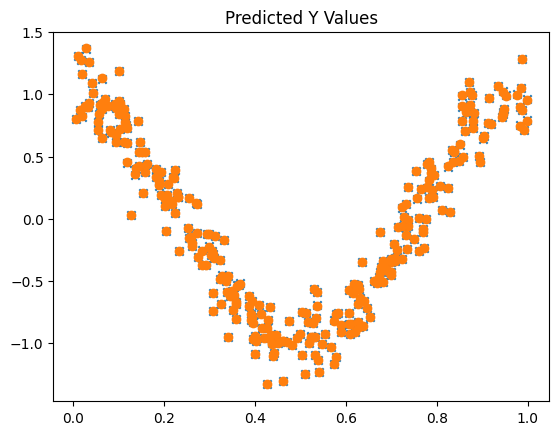

In [375]:

N = 300       # Size of the training dataset
variance = 0.03  # Variance, sigma^2
degree_d=5      # Degree of the model polynomial


data_set = getData(N, variance)
M = 35      # Number of trials
fitData(data_set, degree_d)


In [376]:


##############

# How to do the function math!!!
X_data = numpy.array([1,2,3,4])
deg = 4
coeff = numpy.array([0.5,0.5,0.5,0.5,0.5])

polynomial = numpy.poly1d(numpy.ones(deg+1))
print(polynomial)
y_values = polynomial(X_data)  # Evaluate the polynomial at the dataset points
print ("Y_vals", y_values)

y_pred_poly = numpy.polyval(coeff, X_data)
print("Polyval evaluation:", y_pred_poly)

y = numpy.array([6,33,124,346])

print("Predicted, y - y_pred_poly", y - y_pred_poly)
print("MSE", getMSEOld(y_pred_poly, y))

# Try the other guys way, ensure same loss
X_vec = numpy.ones((1,len(X_data)))
for i in range(0,deg):
    X_vec = numpy.vstack((X_vec, X_data**(i+1)))
X_vec = X_vec.T
print("X Vector after transpose:", X_vec)
print("Predicted, y - x.dot(coeff)", y - X_vec.dot(coeff))
print("MSE_test", getMSEOld(X_vec.dot(coeff), y))

# Try a 3rd time using this Vander Matrix
matrix_vander = numpy.vander(X_data, deg+1, True) # bool flag flips if it's leading
print("The vander matrix:\n", matrix_vander)

print("Predicted Y - Vander", y - matrix_vander.dot(coeff))
print("MSE Vander", getMSEOld(matrix_vander.dot(coeff), y))



   4     3     2
1 x + 1 x + 1 x + 1 x + 1
Y_vals [  5.  31. 121. 341.]
Polyval evaluation: [  2.5  15.5  60.5 170.5]
Predicted, y - y_pred_poly [  3.5  17.5  63.5 175.5]
MSE 8787.75
X Vector after transpose: [[  1.   1.   1.   1.   1.]
 [  1.   2.   4.   8.  16.]
 [  1.   3.   9.  27.  81.]
 [  1.   4.  16.  64. 256.]]
Predicted, y - x.dot(coeff) [  3.5  17.5  63.5 175.5]
MSE_test 8787.75
The vander matrix:
 [[  1   1   1   1   1]
 [  1   2   4   8  16]
 [  1   3   9  27  81]
 [  1   4  16  64 256]]
Predicted Y - Vander [  3.5  17.5  63.5 175.5]
MSE Vander 8787.75


X data, pre mod:
 [0.17553793 0.67940707 0.85937511]
X data after transpose:
 [[1.00000000e+00 1.75537926e-01 3.08135633e-02 5.40894898e-03
  9.49475684e-04 1.66668992e-04 2.92567291e-05]
 [1.00000000e+00 6.79407069e-01 4.61593965e-01 3.13610203e-01
  2.13068989e-01 1.44760577e-01 9.83513593e-02]
 [1.00000000e+00 8.59375108e-01 7.38525577e-01 6.34670498e-01
  5.45420028e-01 4.68720396e-01 4.02806641e-01]]
Weights: [[0.75438608]
 [0.23365976]
 [0.96196033]
 [0.84509875]
 [0.10821412]
 [0.69242669]
 [0.12410935]]
Y_pred [[0.82983653]
 [1.75770233]
 [2.63554774]]


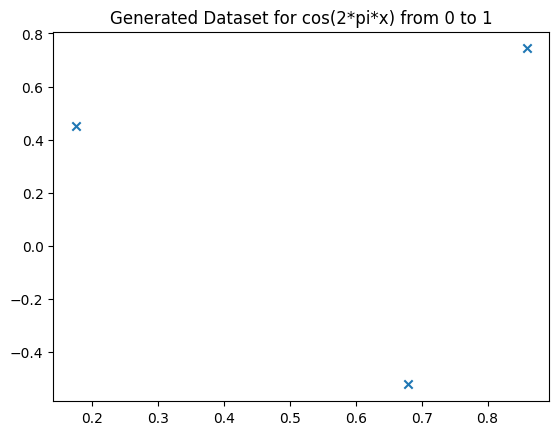

In [377]:
import numpy as np

def GD_Test(X,y,n,weights):
    itr = 2000
    lrate = 0.001
    Ein_list = np.zeros(itr)
    Ein=0
    for i in range(itr):
        weights -= lrate * (2/n) * (((X.dot(weights) - y).T).dot(X).T)
        Ein_list[i] = getMSEOld(X.dot(weights), y)
    Ein = Ein_list[itr-1]
    return weights,Ein

def fitData_Test(data,d):
    y = data[:,1].reshape((len(data),1))
    x = data[:,0]
    print("X data, pre mod:\n", x)
    X = np.ones((1,len(data)))
    for i in range(d):
        X = np.vstack((X, x**(i+1)))
    X= X.T
    print("X data after transpose:\n", X)  # vector of X, evaluated. Nxd+1
    #print("Y data:\n", y)
    
    #initialize weights
    weights = np.random.random([d+1,1])
    print("Weights:", weights)
    print("Y_pred", X.dot(weights))
    #print(((X.dot(weights) - y).T).dot(X).T)
    n=len(data)

    #function setup
    weights,Ein = GD_Test(X,y,n,weights)
    return weights,Ein


def getMSE_TEst(y_pred,y):
    mse = np.mean((y-y_pred)**2)
    return mse


N = 3        # Size of the training dataset
variance = 0.003  # Variance, sigma^2
degree_d=6      # Degree of the model polynomial


data_set = getData(N, variance)
weights2,Ein = fitData_Test(data_set, degree_d)